In [1]:
import numpy as np
import pandas as pd
import os
import calendar
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
pd.options.display.max_columns =100
%matplotlib inline

import tensorflow
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import SimpleRNN, Dense

In [2]:
def readAllCSV():

  month_mapping = {month: index for index, month in enumerate(calendar.month_name) if month}

  file_list = os.listdir('data')

  file_list = sorted(file_list, key=lambda x: month_mapping.get(x.split('.')[0]))
  dfs = []
  for file_name in file_list:
      
      file_path = os.path.join('data', file_name)
      df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
      dfs.append(df)
  return dfs

def extractUsefulInfo(table, columns):

  df = table[columns]
  df = df.drop(df.index[0])
  df[columns] = df[columns].astype(float)
  print("Printing NaN's")
  print(df.isna().sum())
  df.dropna(inplace=True)
  return df


def plots(df,column,q_low,q_hi):
  # Set the style of the plot
  sns.set_style("whitegrid")

  # Set the thresholds
  low_threshold = df[column].quantile(q_low)
  high_threshold = df[column].quantile(q_hi)

  # Filter the data
  filtered_data = df[
      (df[column] >= low_threshold) &
      (df[column] <= high_threshold)
  ]

  # Downsampling the data
  max_data_points = 2000  # Maximum number of data points to plot
  if len(filtered_data) > max_data_points:
      indices = np.linspace(0, len(filtered_data) - 1, max_data_points, dtype=int)
      downsampled_data = filtered_data.iloc[indices]
  else:
      downsampled_data = filtered_data

  # Create the plot using Seaborn
  plt.figure(figsize=(10, 6))
  sns.lineplot(x='date', y=column, data=downsampled_data)

  # Set the x-axis tick labels
  num_ticks = 10
  step = len(downsampled_data) // num_ticks
  x_ticks = downsampled_data['date'][::step]
  plt.xticks(x_ticks, rotation=90)

  # Set the plot labels and title
  plt.xlabel('Date')
  plt.ylabel(column)
  plt.title('Visualization of ' + column + ' (Filtered)')

  # Display the plot
  plt.show()


In [3]:
df_list = readAllCSV()

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_21508\1058617968.py:12: DtypeWarning: Columns (3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter = ';',  encoding = 'latin-1')
C:\Users\Mitsos\AppData\Local\Temp\ipykernel_21508\1058617968.py:12: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, delimiter = ';',  encoding = '

In [4]:
june = df_list[1]

In [5]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv']

june_first = extractUsefulInfo(june,columns)
june_first['date'] = june['date']

Printing NaN's
separator_speed_rpm_pv      10
mill_dp_mbar_pv             14
separator_pwr_kw_pv         14
cement_type_cpii_bool_pv    14
dtype: int64


In [6]:
june_first = june_first[june_first['cement_type_cpii_bool_pv']==1.0]
june_first.drop(['cement_type_cpii_bool_pv'], axis=1, inplace=True)
june_first

,separator_speed_rpm_pv,mill_dp_mbar_pv,separator_pwr_kw_pv,date
1,13.63,1.73,1.07,1/6/2019 0:00
2,13.73,1.88,1.07,1/6/2019 0:00
3,13.78,1.89,1.07,1/6/2019 0:01
4,13.73,1.74,1.07,1/6/2019 0:01
5,13.73,1.88,1.07,1/6/2019 0:02
...,...,...,...,...
73115,771.01,31.64,55.65,30/6/2019 7:11
73116,769.85,31.09,55.55,30/6/2019 7:11
73117,767.63,30.35,56.46,30/6/2019 7:11
73118,768.47,30.14,56.60,30/6/2019 7:11


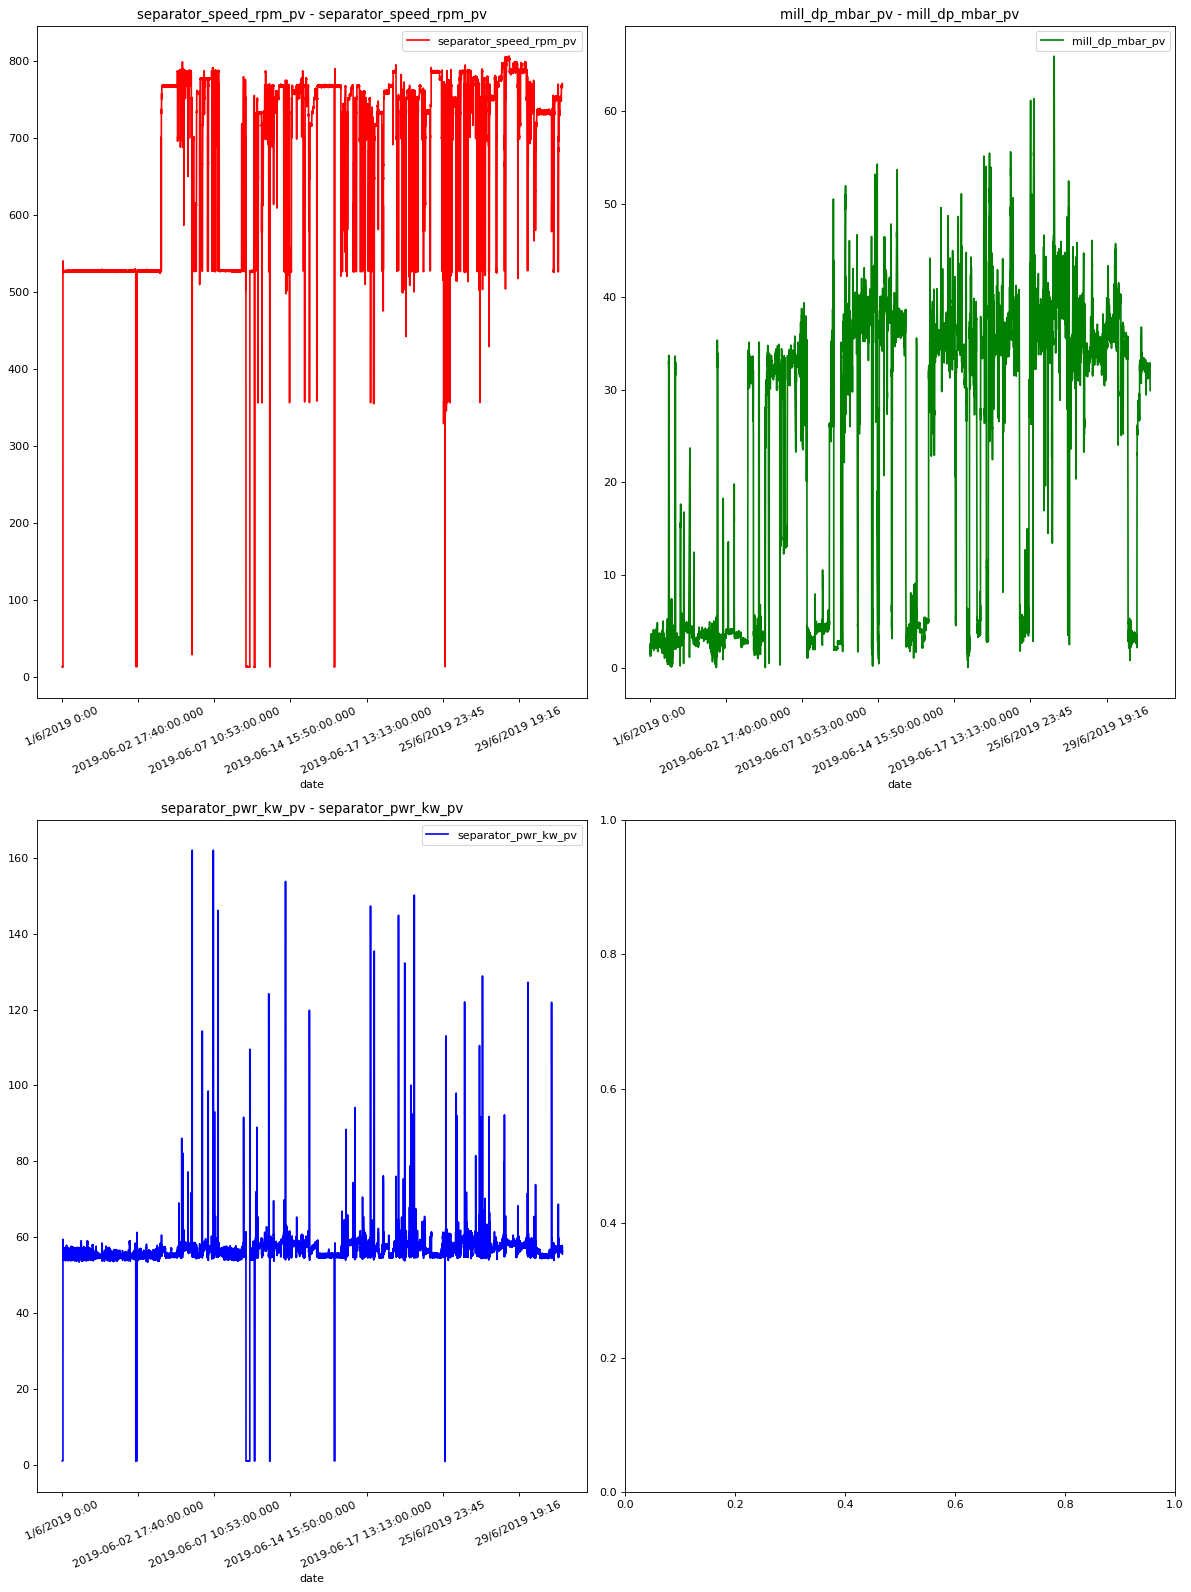

In [7]:
feature_keys = [
    "separator_speed_rpm_pv",
    "mill_dp_mbar_pv",
    "separator_pwr_kw_pv"
]

titles = feature_keys

date_time_key = "date"
colors = ["red", "green", "blue", "grey"]
def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=2, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(june_first)

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_21508\49938216.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.matshow(data.corr())


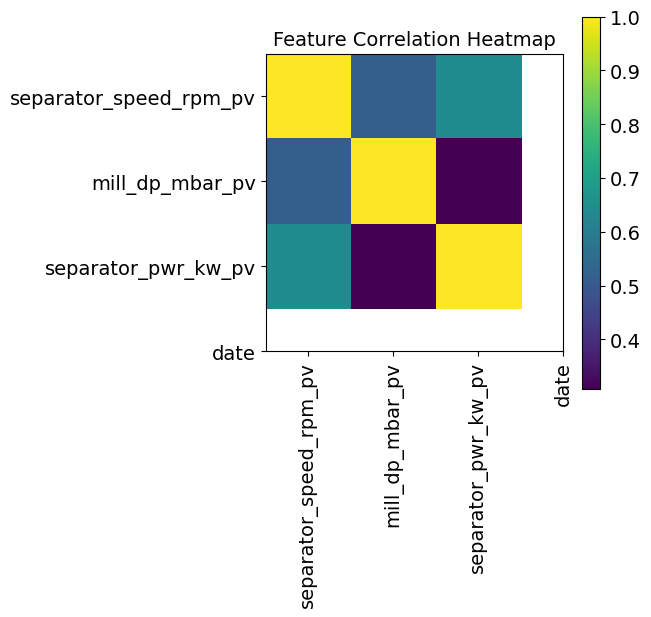

In [8]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(june_first)

### RNN (new)

In [9]:
features = june_first.drop(['date'], axis=1)
features.index = june_first[date_time_key]

split_fraction = 0.715
train_split = int(split_fraction * int(june_first.shape[0]))
step = 1

past = 20
future = 10 #after 10 timestamps
learning_rate = 0.001
batch_size = 256
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [10]:
features = normalize(features.values, train_split)
features = pd.DataFrame(features)

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [11]:
start = past + future
end = start + train_split

x_train = train_data[[i for i in range(3)]].values
y_train = features.iloc[start:end][[2]]

sequence_length = int(past / step)

In [12]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [13]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end][[i for i in range(3)]].values
y_val = features.iloc[label_start:][[2]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_train.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 20, 3)
Target shape: (256, 1)


In [14]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20, 3)]           0         
                                                                 
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [15]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback],
)

Epoch 1/10
89/92 [============================>.] - ETA: 0s - loss: 0.6186
Epoch 1: val_loss improved from inf to 0.10752, saving model to model_checkpoint.h5
92/92 [==============================] - 5s 29ms/step - loss: 0.6094 - val_loss: 0.1075
Epoch 2/10
89/92 [============================>.] - ETA: 0s - loss: 0.4615
Epoch 2: val_loss did not improve from 0.10752
92/92 [==============================] - 2s 17ms/step - loss: 0.4570 - val_loss: 0.1078
Epoch 3/10
90/92 [============================>.] - ETA: 0s - loss: 0.3839
Epoch 3: val_loss did not improve from 0.10752
92/92 [==============================] - 1s 15ms/step - loss: 0.3824 - val_loss: 0.1095
Epoch 4/10
89/92 [============================>.] - ETA: 0s - loss: 0.3400
Epoch 4: val_loss did not improve from 0.10752
92/92 [==============================] - 1s 15ms/step - loss: 0.3391 - val_loss: 0.1113
Epoch 5/10
90/92 [============================>.] - ETA: 0s - loss: 0.3157
Epoch 5: val_loss did not improve from 0.10752
9

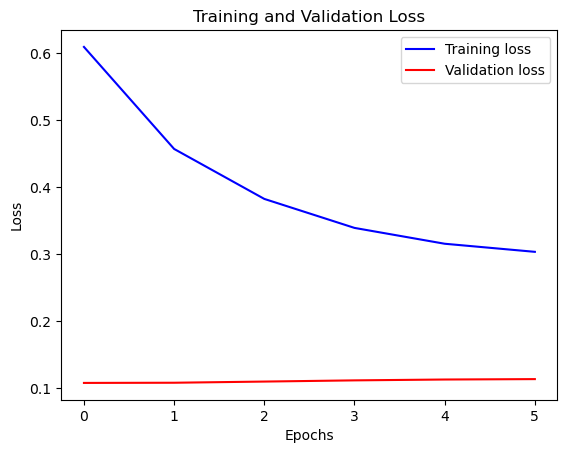

In [16]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")


8/8 [==============================] - 0s 3ms/step


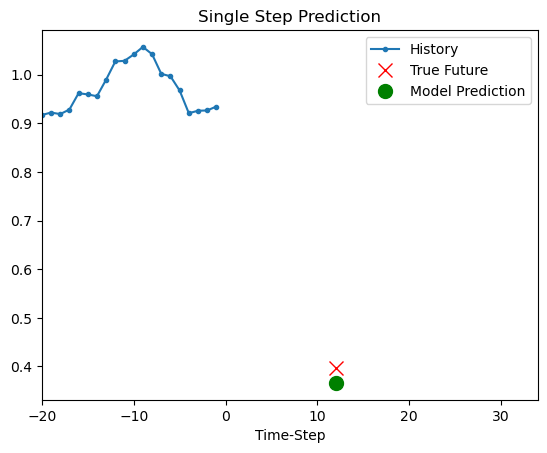

8/8 [==============================] - 0s 3ms/step


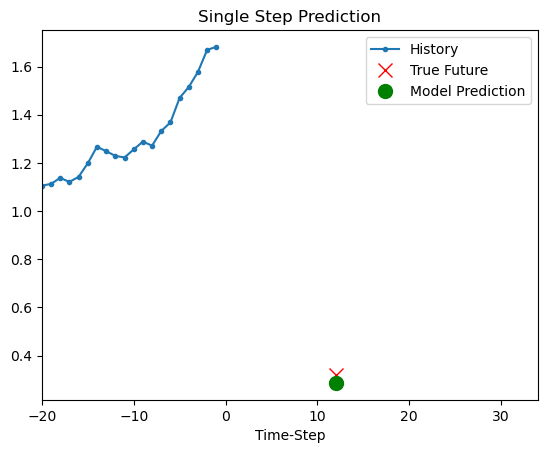

8/8 [==============================] - 0s 3ms/step


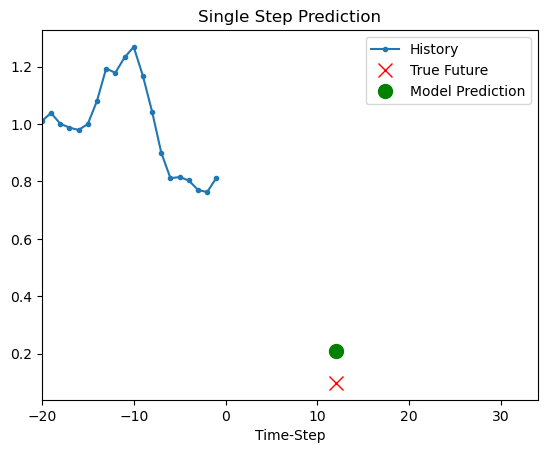

8/8 [==============================] - 0s 2ms/step


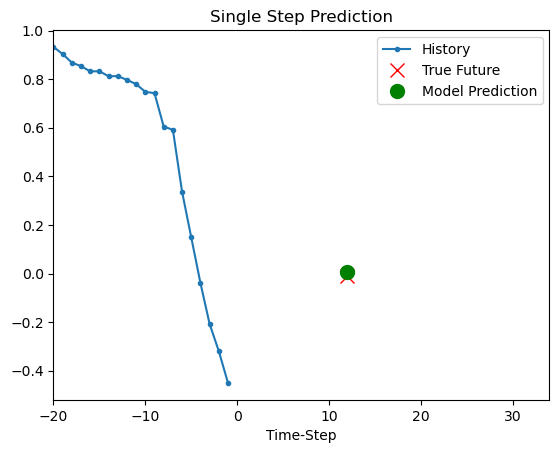

8/8 [==============================] - 0s 3ms/step


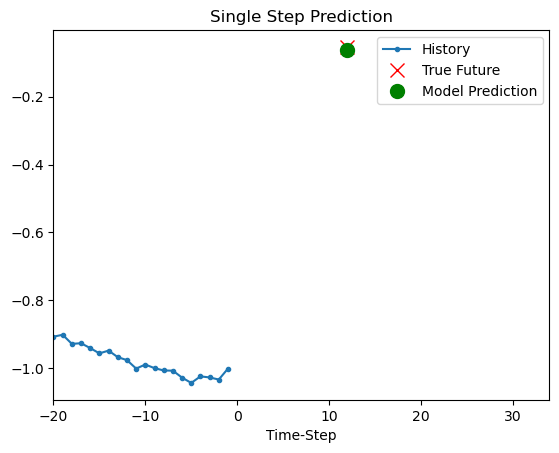

In [17]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return


for x, y in dataset_val.take(5):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_21508\1189744188.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = june_first.corr()


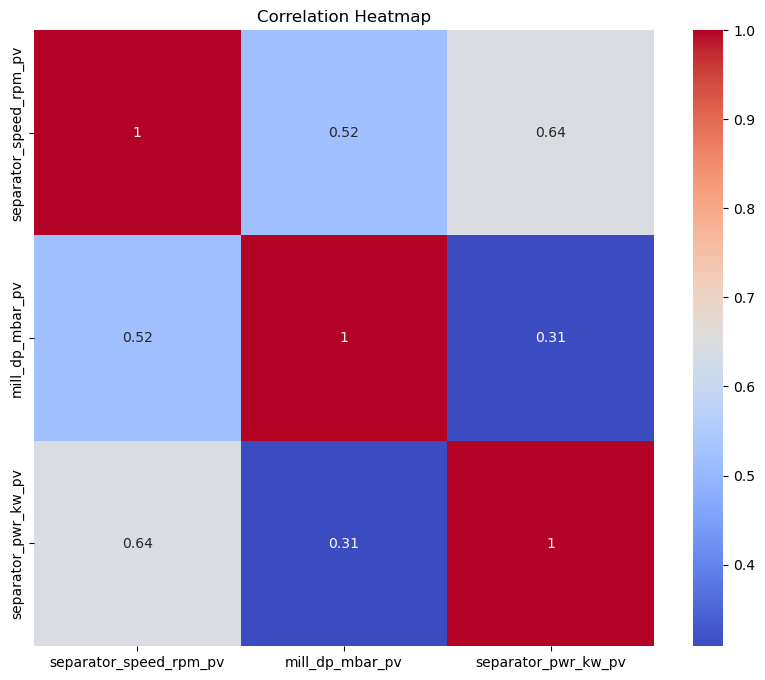

In [18]:
correlation_matrix = june_first.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [20]:
shifted_df = june_first[['separator_speed_rpm_pv', 'mill_dp_mbar_pv']].shift(10)

# Concatenate the shifted columns with the original dataframe
shifted_df = pd.concat([june_first.drop(['separator_speed_rpm_pv', 'mill_dp_mbar_pv'] , axis=1), shifted_df], axis=1)

# Drop rows with NaN values introduced by the shifting
shifted_df = shifted_df.dropna()

# Print the resulting dataframe with shifted columns
print(shifted_df)

       separator_pwr_kw_pv            date  separator_speed_rpm_pv  \
11                    1.07   1/6/2019 0:05                   13.63   
12                    1.06   1/6/2019 0:05                   13.73   
13                    1.07   1/6/2019 0:06                   13.78   
14                    1.06   1/6/2019 0:06                   13.73   
15                    1.06   1/6/2019 0:07                   13.73   
...                    ...             ...                     ...   
73115                55.65  30/6/2019 7:11                  765.31   
73116                55.55  30/6/2019 7:11                  766.36   
73117                56.46  30/6/2019 7:11                  767.52   
73118                56.60  30/6/2019 7:11                  766.63   
73119                56.45  30/6/2019 7:12                  767.58   

       mill_dp_mbar_pv  
11                1.73  
12                1.88  
13                1.89  
14                1.74  
15                1.88  
...      

C:\Users\Mitsos\AppData\Local\Temp\ipykernel_21508\472705834.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = shifted_df.corr()


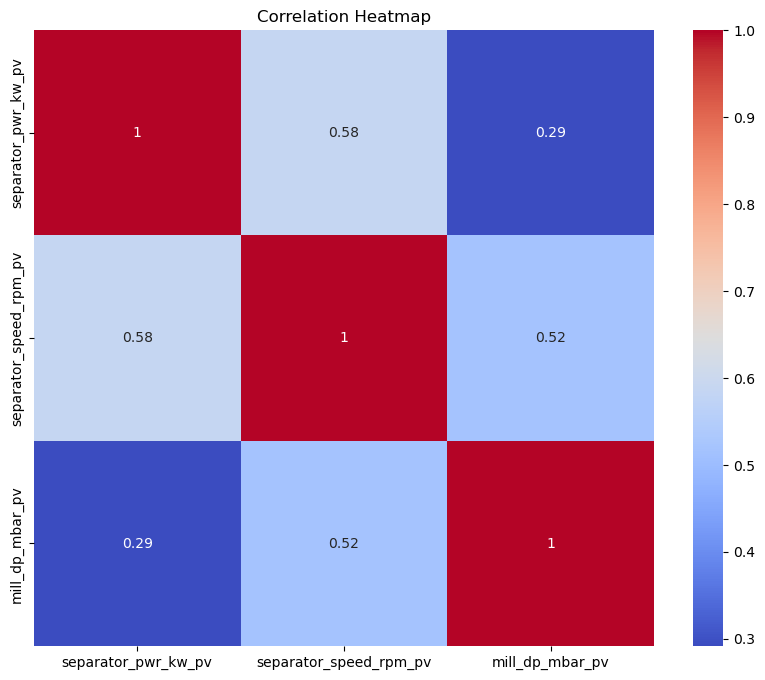

In [21]:
correlation_matrix = shifted_df.corr()

# Create a correlation heatmap using Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
columns = ['separator_speed_rpm_pv', 'mill_dp_mbar_pv', 'separator_pwr_kw_pv', 'cement_type_cpii_bool_pv']

june_first = extractUsefulInfo(june,columns)
june_first['date'] = june['date']

In [ ]:
july = df_list[2]
july_first = extractUsefulInfo(july,columns)
july_first

In [ ]:
q_low = 0.01
q_hi = 0.99
plots(june_first,'mill_dp_mbar_pv',q_low,q_hi)


In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_pwr_kw_pv',q_low,q_hi)

In [ ]:
q_low = 0.05
q_hi = 0.95
plots(june_first,'separator_speed_rpm_pv',q_low,q_hi)

In [ ]:
# Normalize data
sc = StandardScaler()
X = june_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y = june_first['separator_speed_rpm_pv']
X_test = july_first[['mill_dp_mbar_pv', 'separator_pwr_kw_pv']]
y_test =  july_first['separator_speed_rpm_pv']

X = sc.fit_transform(X)
X_test= sc.transform(X_test)


In [ ]:
# Linear Regression
model = LinearRegression()


model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# RandomForest Regressor

# My max_depth=16
param_grid = {
    'n_estimators' : [10, 50, 100, 200, 1000],
    'criterion' : ['squared_error','absolute_error', 'friedman_mse', 'poisson'],
    'max_depth' : [None, 4, 8, 12],
    'min_samples_split' : [2, 5, 8]
}
model = RandomForestRegressor()

gs = GridSearchCV(model,param_grid,scoring='neg_mean_squared_error',verbose=10,n_jobs =-1)
#gs.fit(X,y)
model.fit(X, y)

predictions = model.predict(X_test)

plt.scatter(y_test, predictions)
plt.plot(np.linspace(0, np.max(y_test), 100), np.linspace(0, np.max(y_test), 100), color='red', linestyle='--')
plt.xlabel('Actual Values (y_test)')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.show()

In [ ]:
# IGNORE einai gia to deutero, apla evlepa.

columns = ['total_feed_ton/h_pv', 'fly_ash_1_ton/h_pv', 'fly_ash_2_ton/h_pv',
           'main_fan_speed_rpm_pv', 'separator_speed_rpm_pv', 'grinding_pressure_bar_pv',
           'mill_injection_water_m3/h_pv', 'bucket_elv_mtr_pwr_kw_pv', 'mill_dp_mbar_pv']

second = extractUsefulInfo(june,columns)